In [1]:
import pandas as pd
import pmxNCMC
import numpy as np
from pathlib import Path
import pymbar

from scipy.stats import sem
import matplotlib.pyplot as plt

# Question
In state A, it's a normal 2-pentene. In state B, the dihedrals on the double bond are removed. We are calculating this free energy with different starting structure. If the enhance sampling works, 2 starting structures should converge to the same value.

In [2]:
T = 323.0

# load csv

In [9]:
base_t = Path("01-trans")
df_t = []
for p in base_t.glob("rep_?/md.csv"):
    df = pd.read_csv(p)
    if len(df) == 200:
        df_t.append(df)


In [15]:
base_c = Path("02-cis")
df_c = []
for p in base_c.glob("rep_?/md.csv"):
    df = pd.read_csv(p)
    if len(df) == 200:
        df_c.append(df)

In [16]:
kBT      = pmxNCMC.util.kB_kj_mol * T
kBT_kcal = pmxNCMC.util.kB_kcal_mol * T

# Estimate $\Delta G$

In [17]:
def freeE(n_start, n_end, df_t, df_c):
    """
    take the [n_start:n_end] sample and estimate the free E
    """
    dG_t = []
    dG_c = []
    for df_list, dG_list in ((df_t, dG_t),(df_c, dG_c)):
        for df in df_list:
            work01 = df[df.columns[1]][n_start:n_end]
            work10 = df[df.columns[2]][n_start:n_end]
            res = pymbar.other_estimators.bar(work01/kBT, work10/kBT)
            dG = res["Delta_f"]
            dGe = res["dDelta_f"]
            dG_list.append(dG*kBT_kcal)
    return dG_t, dG_c


In [18]:
x_list = [40, 60, 80, 100, 120, 140, 200]
t_dG_ave = []
t_dG_sem = []
c_dG_ave = []
c_dG_sem = []
for n in x_list:
    dG_t, dG_c = freeE(n//4,n, df_t, df_c)
    t_dG_ave.append(np.mean(dG_t))
    t_dG_sem.append(sem(dG_t))
    c_dG_ave.append(np.mean(dG_c))
    c_dG_sem.append(sem(dG_c))
t_dG_ave = np.array(t_dG_ave)
t_dG_sem = np.array(t_dG_sem)
c_dG_ave = np.array(c_dG_ave)
c_dG_sem = np.array(c_dG_sem)

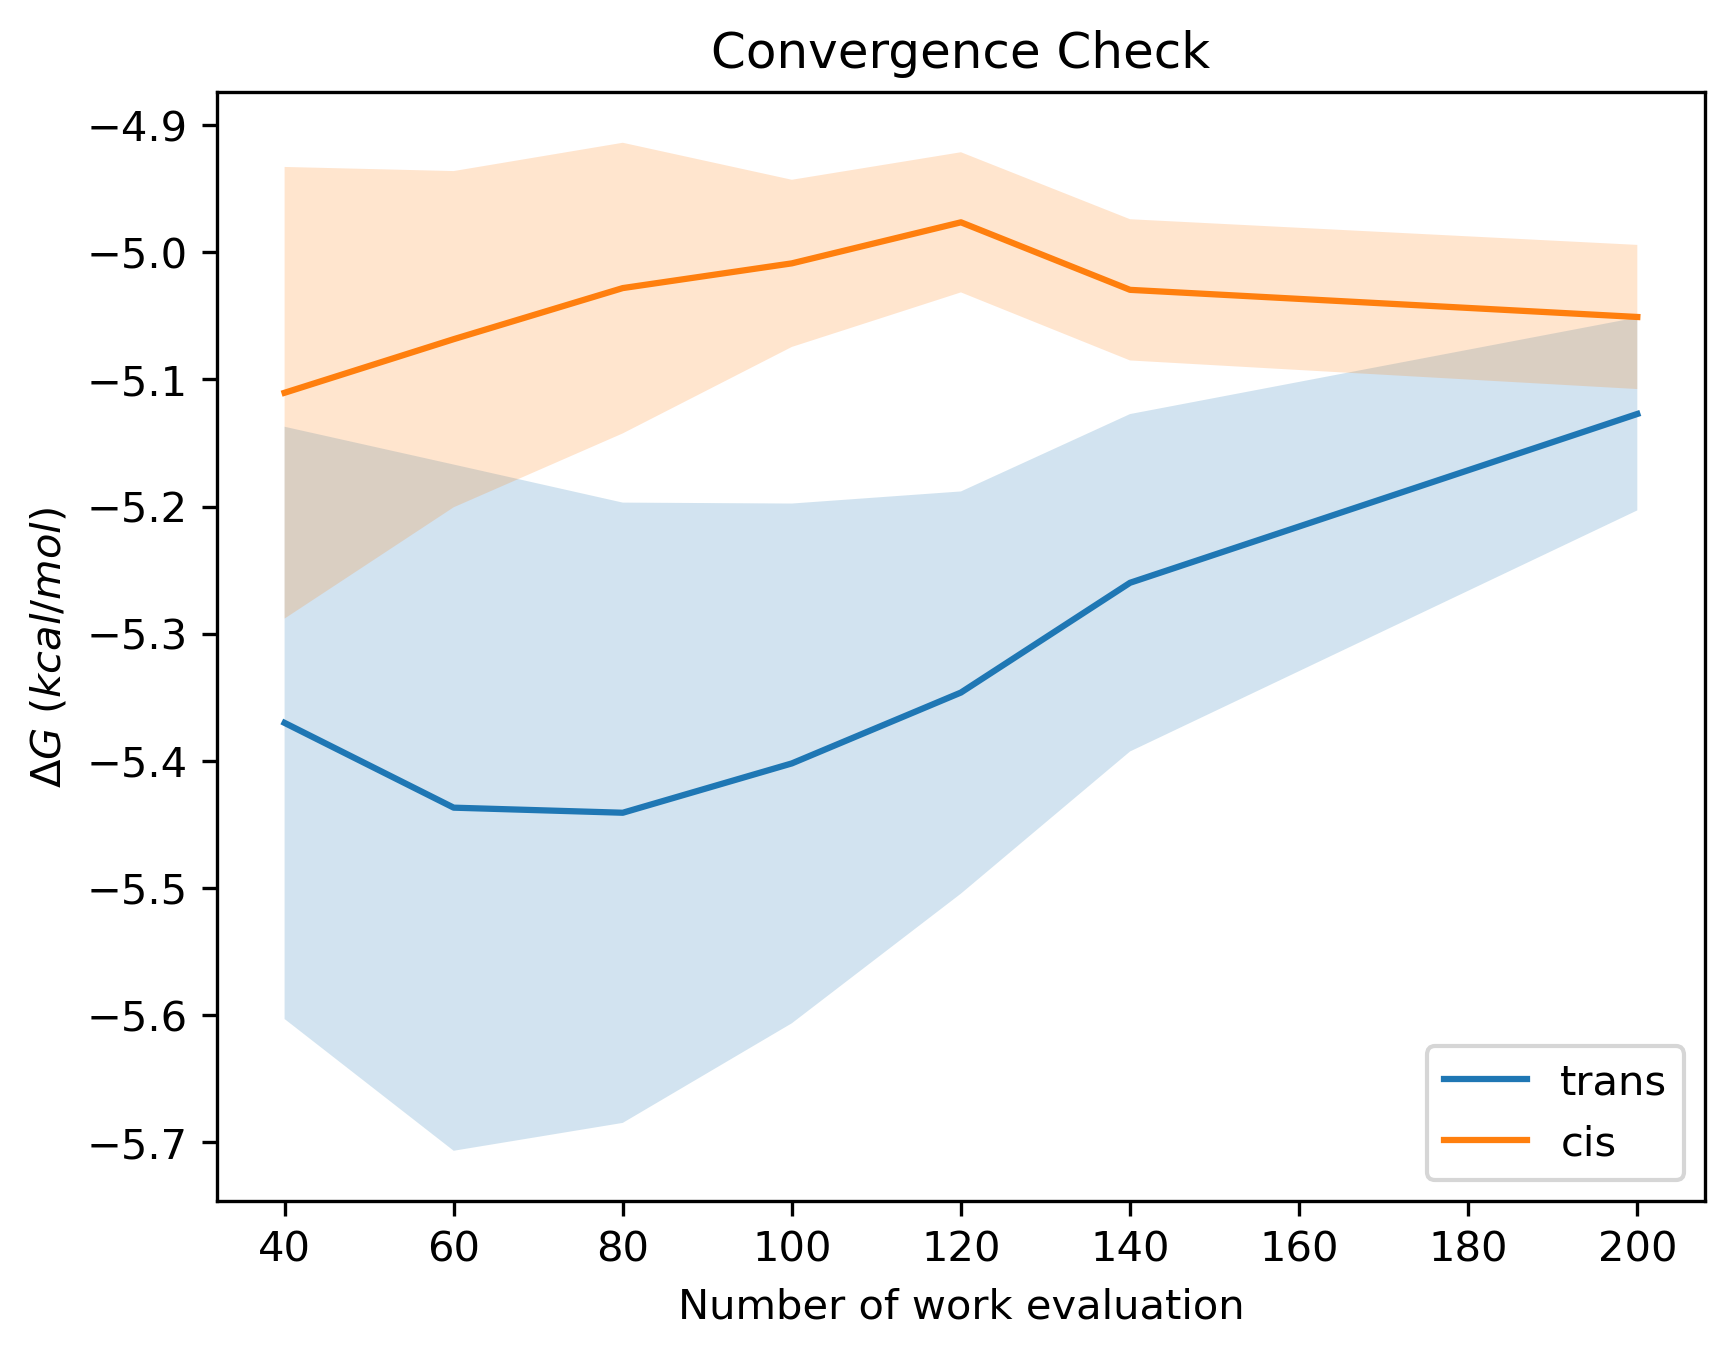

In [20]:
fig, ax = plt.subplots(1,1, dpi=300)
ax.plot(x_list, t_dG_ave, label="trans")
ax.fill_between(x_list, t_dG_ave - t_dG_sem, t_dG_ave + t_dG_sem, alpha=0.2)
ax.plot(x_list, c_dG_ave, label="cis")
ax.fill_between(x_list, c_dG_ave - c_dG_sem, c_dG_ave + c_dG_sem, alpha=0.2)
ax.legend()

ax.set_xlabel("Number of work evaluation")
ax.set_ylabel(r"$\Delta G\ (kcal/mol)$")
ax.set_title("Convergence Check")

fig.savefig("convergence.png", bbox_inches='tight')